# Variable Taxi Fuel

In [1]:
import numpy as np
import pandas as pd
import os.path
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import seaborn as sns

from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn import mixture

import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import accuracy_score


from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline

## Data Exploration - DOT & OOOI

In [2]:
#Exploring DOT data
DOT_df = pd.read_csv('Inputs/DOT/DOT_data.csv')
print(DOT_df.head())

#Exploring AAY-specific OOOI data
OOOI_df = pd.read_csv('Inputs/OOOI_data.csv')
print(OOOI_df.head())

   ARR_HOUR  ARR_TIME  CANCELLED CARRIER  CARRIER_DELAY  DEP_HOUR  DEP_TIME  \
0        21      2120        0.0      DL            NaN        19      1935   
1        23      2319        0.0      DL            NaN        21      2130   
2         5       547        0.0      DL            NaN        22      2256   
3        22      2213        0.0      DL            NaN        17      1700   
4        10      1053        0.0      DL            NaN         9       946   

  DEST  DEST_AIRPORT_ID  DIVERTED  ...  ORIGIN_AIRPORT_ID  SECURITY_DELAY  \
0  LAX            12892       0.0  ...              11433             NaN   
1  GRR            11986       0.0  ...              10397             NaN   
2  ATL            10397       0.0  ...              12892             NaN   
3  ATL            10397       0.0  ...              14869             NaN   
4  JAX            12451       0.0  ...              10397             NaN   

   TAIL_NUM  TAXI_IN  TAXI_OUT Unnamed: 21  WEATHER_DELAY  WHE

In [3]:
# ax = sns.regplot(x="DEP_HOUR", y="TAXI_OUT", data=DOT_df)
DOT_year = DOT_df[DOT_df['YEAR'] == 2017]
dep_volume_df = DOT_year.groupby(by=['ORIGIN', 'YEAR', 'MONTH', 'DEP_HOUR'], level=None, as_index=False, sort=True).count().iloc[:,:5]
dep_volume_df = dep_volume_df.rename(columns={dep_volume_df.columns[4]: "dep_vol" })
DOT_year = DOT_year.merge(dep_volume_df)
print(DOT_year.head())

   ARR_HOUR  ARR_TIME  CANCELLED CARRIER  CARRIER_DELAY  DEP_HOUR  DEP_TIME  \
0        10      1017        0.0      HA            NaN         7       739   
1        10      1007        0.0      AS            NaN         7       705   
2         9       944        0.0      DL            NaN         7       708   
3        13      1305        0.0      DL            NaN         7       732   
4        15      1523        0.0      DL            NaN         7       717   

  DEST  DEST_AIRPORT_ID  DIVERTED   ...    SECURITY_DELAY  TAIL_NUM  TAXI_IN  \
0  HNL            12173       0.0   ...               NaN    N395HA      5.0   
1  SEA            14747       0.0   ...               NaN    N622AS     26.0   
2  SEA            14747       0.0   ...               NaN    N372DA      7.0   
3  MSP            13487       0.0   ...               NaN    N535US      6.0   
4  JFK            12478       0.0   ...               NaN    N829MH      5.0   

   TAXI_OUT  Unnamed: 21 WEATHER_DELAY  WHEE

C:\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


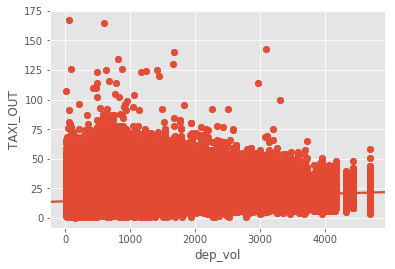

In [4]:
ax = sns.regplot(x="dep_vol", y="TAXI_OUT", data=DOT_year)
plt.show()

In [5]:
OOOI_year = OOOI_df[OOOI_df['YEAR'] == 2017]
OOOI_year['origin'] = OOOI_year.ORG.astype("category").cat.codes
OOOI_origin_map = list(set(zip(OOOI_year.ORG, OOOI_year.origin)))
print(OOOI_year.head())
print(OOOI_origin_map[:5])

       FlightRecId                 Date  Flight  Leg      CategoryDescr  \
11431       706838  2017-09-03 00:00:00     100    1  Scheduled Service   
11432       706840  2017-09-10 00:00:00     100    1  Scheduled Service   
11433       706841  2017-09-14 00:00:00     100    1  Scheduled Service   
11434       706842  2017-09-17 00:00:00     100    1  Scheduled Service   
11435       706843  2017-09-21 00:00:00     100    1  Scheduled Service   

        TAIL  ORG  DST           AIS_Out                  OUT   ...    \
11431  326NV  IWA  CID  22:19:00.0000000  1900-01-01 22:12:00   ...     
11432  331NV  IWA  CID  22:31:00.0000000  1900-01-01 22:31:00   ...     
11433  326NV  IWA  CID  20:48:00.0000000  1900-01-01 20:48:00   ...     
11434  303NV  IWA  CID  22:37:00.0000000  1900-01-01 22:39:00   ...     
11435  308NV  IWA  CID  21:23:00.0000000  1900-01-01 21:23:00   ...     

                        ON            AIS_In                   IN MONTH  YEAR  \
11431  1900-01-01 01:14:00  0

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


## Model intialization - XGBoost

In [4]:
DOT_year['origin'] = DOT_year.ORIGIN.astype("category").cat.codes
DOT_origin_map = list(set(zip(DOT_year.ORIGIN, DOT_year.origin)))
print(DOT_year.head())
print(DOT_origin_map[:5])

   ARR_HOUR  ARR_TIME  CANCELLED CARRIER  CARRIER_DELAY  DEP_HOUR  DEP_TIME  \
0        10      1017        0.0      HA            NaN         7       739   
1        10      1007        0.0      AS            NaN         7       705   
2         9       944        0.0      DL            NaN         7       708   
3        13      1305        0.0      DL            NaN         7       732   
4        15      1523        0.0      DL            NaN         7       717   

  DEST  DEST_AIRPORT_ID  DIVERTED   ...   TAIL_NUM  TAXI_IN  TAXI_OUT  \
0  HNL            12173       0.0   ...     N395HA      5.0      14.0   
1  SEA            14747       0.0   ...     N622AS     26.0      23.0   
2  SEA            14747       0.0   ...     N372DA      7.0      18.0   
3  MSP            13487       0.0   ...     N535US      6.0      16.0   
4  JFK            12478       0.0   ...     N829MH      5.0      21.0   

   Unnamed: 21  WEATHER_DELAY WHEELS_OFF  WHEELS_ON  YEAR dep_vol  origin  
0         

In [18]:
# Randomly sort the data then split out first 70%, second 20%, and last 10%
train_data, validation_data, test_data = np.split(DOT_year[['YEAR', 'MONTH', 'origin', 'dep_vol', 'DEP_HOUR', 'TAXI_OUT']].sample(frac=1, random_state=1729), 
                                                  [int(0.7 * len(DOT_year)), int(0.9 * len(DOT_year))]) 

print(train_data.shape, validation_data.shape, test_data.shape)
print(train_data.head())

(4193338, 6) (1198097, 6) (599049, 6)
         YEAR  MONTH  origin  dep_vol  DEP_HOUR  TAXI_OUT
3770522  2017     12     223      132        19      17.0
2354056  2017     10     280     1058         6      14.0
1945225  2017      9      89     1022         7      13.0
3153835  2017     12     137      354        22      21.0
2406760  2017     10      20     4326        10      15.0


In [6]:
# X_y_train = xgb.DMatrix(data=train_data[['YEAR', 'MONTH', 'origin', 'dep_vol', 'DEP_HOUR', 'TAXI_OUT']], 
#                         label=train_data['TAXI_OUT'])
# X_validation = xgb.DMatrix(data=validation_data[['YEAR', 'MONTH', 'origin', 'dep_vol', 'DEP_HOUR', 'TAXI_OUT']])

xgb_model = XGBRegressor(learning_rate=0.2, n_estimators=100, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, 
                         colsample_bytree=0.8, objective= 'reg:linear', nthread=4, scale_pos_weight=1, seed=27)

cv_folds = 5
early_stopping_rounds = 50
xgb_param = xgb_model.get_xgb_params()
xgtrain = xgb.DMatrix(train_data[['YEAR', 'MONTH', 'origin', 'dep_vol', 'DEP_HOUR']].values, label=train_data['TAXI_OUT'].values)
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb_model.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
xgb_model.set_params(n_estimators=cvresult.shape[0])


xgb_model.fit(train_data[['YEAR', 'MONTH', 'origin', 'dep_vol', 'DEP_HOUR']], train_data['TAXI_OUT'], eval_metric='rmse')


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27, silent=True,
       subsample=0.8)

(1198097,)
         YEAR  MONTH  origin  dep_vol  DEP_HOUR  TAXI_OUT  Predicted_TaxiOut
1671846  2017      9      89     2562         8      14.0               19.0
1500482  2017      7     176       68        13      18.0               14.0
2674554  2017     10     178      820        10      30.0               26.0
1529279  2017      7     178      382        19      27.0               21.0
4631976  2017      2     172     1230         6      11.0               17.0
[0.         0.12996992 0.33578348 0.30704978 0.2271968 ]
Accuracy: 7.67%
-12.508654194286121


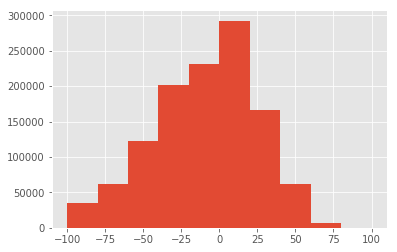

In [53]:
y_validation = xgb_model.predict(validation_data[['YEAR', 'MONTH', 'origin', 'dep_vol', 'DEP_HOUR']])
print(y_validation.shape)
validation_data['Predicted_TaxiOut'] = [round(x) for x in y_validation]
print(validation_data.head())

print(xgb_model.feature_importances_)

accuracy = accuracy_score(validation_data['TAXI_OUT'].values.round(), y_validation.round())
print("Model accuracy: %.2f%%" % (accuracy * 100.0))

delta = (validation_data['TAXI_OUT']-validation_data['Predicted_TaxiOut'])/validation_data['TAXI_OUT']*100
delta = delta.replace([np.inf, -np.inf], np.nan)
delta = delta.dropna()
print('Mean % Error is:', np.mean(delta.values))

plt.hist(delta, range=(-100,100))
plt.show()


## Model initialization - LASSO

In [65]:
def lasso_model(train_data2, test_data2):
    # Alpha (regularization strength) of LASSO regression
    lasso_eps = 0.0001
    lasso_nalpha=10
    lasso_iter=1000

    # Min and max degree of polynomials features to consider
    degree_min = 2
    degree_max = 6

    # Make a pipeline model with polynomial transformation and LASSO regression with cross-validation, run it for increasing degree of polynomial (complexity of the model)
    for degree in range(degree_min,degree_max+1):
        model = make_pipeline(PolynomialFeatures(degree, interaction_only=False), 
                              LassoCV(eps=lasso_eps,n_alphas=lasso_nalpha,max_iter=lasso_iter, normalize=True,cv=5))

        model.fit(train_data2[['YEAR', 'MONTH', 'origin', 'dep_vol', 'DEP_HOUR']].values, train_data2['TAXI_OUT'].values)
        test_pred = np.array(model.predict(test_data2[['YEAR', 'MONTH', 'origin', 'dep_vol', 'DEP_HOUR']].values))
        RMSE=np.sqrt(np.sum(np.square(test_pred-test_data2['TAXI_OUT'].values)))
        test_score = model.score(test_data2[['YEAR', 'MONTH', 'origin', 'dep_vol', 'DEP_HOUR']].values, test_data2['TAXI_OUT'].values)

    print(test_pred)
    print(test_score)
    print(degree)
    
    return test_pred, test_score

In [66]:
origin, airport_code = zip(*DOT_origin_map)
origin='LEX'
for airport in list(origin):
    code_index = list(origin).index(airport)
    code = list(airport_code)[code_index]
    train_data2 = train_data[train_data['origin'] == code]
    test_data2 = test_data[test_data['origin'] == code]
    test_pred, test_score = lasso_model(train_data2, test_data2)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with v

C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with v

C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with v

C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with v

C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with v

[13.28291945 14.36917548 18.66338862 13.28291945 14.35306014 13.15944578
 15.0997584  13.28291945 18.66338862 14.19024619 13.15944578 13.48316167
 14.27326963 12.13163105 14.27098263 13.15944578 14.27326963 14.14381176
 13.48316167 13.28291945 15.0997584  13.76694016 14.27098263 12.13163105
 14.45644171 14.27098263 13.15944578 14.14381176 18.66338862 14.19024619
 14.36917548 13.15944578 14.36917548  9.27599363 14.41077101  8.86272064
 14.27098263 13.28291945 14.41077101 14.41077101 14.41077101 14.35306014
 13.76694016 12.13163105 18.66338862 14.19024619 13.15944578 14.45644171
 14.19024619 14.36917548 14.14381176 15.0997584  12.13163105 14.19024619
 14.27326963 12.13163105 15.0997584  14.36917548 18.66338862 13.28291945
 15.0997584  14.45644171 14.02600473 14.35306014 14.27098263 14.35306014
 14.35306014 14.36917548 14.27326963 14.35306014 14.45644171]
-0.012835098328767724
6


C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with v

C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with v

C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with v

C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with v

[16.27760167 16.45539321 15.98722633 ... 17.96556581 16.6282074
 16.40935169]
0.025192474337375922
6


C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with v

C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with v

C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with v

C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[ 9.55434307  9.79918483 10.54217722 ...  9.12800039  9.12800039
 10.6375389 ]
0.07870013577549717
6


C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Mean % Error is: -12.094456608222899


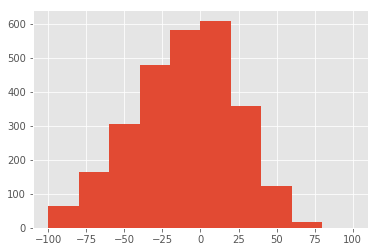

In [67]:
delta2 = ((test_data2['TAXI_OUT']-test_pred)/test_data2['TAXI_OUT']*100)
print('Mean % Error is:', delta2.mean())

plt.hist(delta2, range=(-100,100))
plt.show()